(multilevel_hgf)=
# Embeding Hierarchical Gaussian Filters in a multilevel Bayesian model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/3-Multilevel_HGF.ipynb)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install pyhgf watermark

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from numpy import loadtxt
from pyhgf import load_data
from pyhgf.distribution import HGFDistribution, hgf_logp
from pyhgf.model import HGF
from pyhgf.response import binary_softmax_inverse_temperature
import pytensor.tensor as tt

In [3]:
np.random.seed(123)

In the previous tutorials, we discussed using binary, categorical and continuous Hierarchical Gaussian Filters (HGF) with different levels of volatility. By creating HGF networks this way, we were simulating computations occurring at the agent level (i.e. both the observations and actions were made by one agent, and we estimated the posterior density distribution of parameters for that agent). However, many situations in experimental neuroscience and computational psychiatry will require us to go one step further and to make inferences at the population level, therefore fitting many models at the same time and estimating the density distribution of hyper-priors (see for example case studies from {cite:p}`2014:lee`). 

Luckily, we already have all the components in place to do that. We already used Bayesian networks in the previous sections when we were inferring the distribution of some parameters. Here, we only had one agent (i.e. one participant), and therefore did not need any hyperprior. We need to extend this approach a bit, and explicitly state that we want to fit many models (participants) simultaneously, and draw the values of some parameters from a hyper-prior (i.e. the group-level distribution).

But before we move forward, maybe it is worth clarifying some of the terminology we use, especially as, starting from now, many things are called **networks** but are pointing to different parts of the workflow. We can indeed distinguish two kinds:
1. The predictive coding neural networks. This is the kind of network that [pyhgf](https://github.com/ilabcode/pyhgf) is designed to handle (see {ref}`#probabilistic_networks`). Every HGF model is an instance of such a network.
2. The Bayesian (multilevel) network is the computational graph that is created with tools like [pymc](https://www.pymc.io/welcome.html). This graph will represent the dependencies between our variables and the way they are transformed.

In this notebook, we are going to create the second type of network and incorporate many networks of the first type in it as custom distribution.

## Simulate a dataset
We start by simulating a dataset that would containt the decisions from a group of participants undergoing a standard one-armed bandit task. We use the same binary time series as reference than from the previous tutorials. This would represent the association between the stimuli and the outcome, this is controlled by the experimenter and here we assume all participants are presented with the same sequence of association.

In [4]:
u, _ = load_data("binary")

Using the same reasoning as in the previous tutorial {ref}`#custom_response_functions`, we simulate the trajectories of beliefs from participants being presented with this sequence of observation. Here, we vary one parameter in the perceptual model, we assume that the tonic volatility from the second level is sampled from a population distribution such as: 

$$
\omega_{2_i} \sim \mathcal{N}(-4.0, 1.0)
$$

This produces belief trajectories that can be used to infer propensity for decision at each time point. Moreover, we will assume that the decision function incorporates the possibility of a bias in the link between the belief and the decision in the form of the inverse temperature parameter, such as:

$$
P(A|\hat{\mu}_1^{(k)}, t) = \frac{1}{1+e^{-t\hat{\mu}_1^{(k)}}}
$$

Where $A$ is a positive association between the stimulus and the outcome and $t$ is the temperature parameter.

In [5]:
def sigmoid(x, temperature):
    """The sigmoid response function with inverse temperature parameter."""
    return 1 / (1 + np.exp(-temperature * x))

In [6]:
N = 10  # number of agents/participants in the study

# create just one default network - we will simply change the values of interest before fitting to save time
agent = HGF(
    n_levels=2,
    verbose=False,
    model_type="binary",
    initial_mean={"1": 0.0, "2": 0.0},
    initial_precision={"1": 0.0, "2": 1e1},
    tonic_volatility={"2": -4.0},
)

# observations (always the same), simulated decisions, samples values for temperature and volatility
inputs, responses, temperatures, volatilities = [], [], [], []
for i in range(N):
    # sample one new value of the tonic volatility at the second level and fit to observations
    volatility = np.random.normal(-4.0, 1.0)
    agent.attributes[2]["tonic_volatility"] = volatility
    agent.input_data(input_data=u)

    # sample one value for the inverse temperature (here in log space) and simulate responses
    temperature = np.exp(np.random.normal(.5, .5))
    p = sigmoid(x=agent.node_trajectories[1]["expected_mean"], temperature=temperature)

    # store observations and decisions separately
    inputs.append(u)
    responses.append(np.random.binomial(p=p, n=1))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## A multilevel binary HGF
In this part, we start embedding the HGF in a multilevel model using PyMC. We use the same core distribution (the [HGFDistribution class](pyhgf.distribution.HGFDistribution)) and leverage the possibility of automatic broadcasting (see below) to apply the same procedure to multiple HGF models in parallel. Note that the list of observations and decisions from all participants is provided and stored when we create the [PyTensor](https://pytensor.readthedocs.io) Op instance so it is not necessary to provide it thereafter.

```{hint} Using automatic broadcasting
To estimate group-level parameters, we will have to fit multiple models at the same time, either on different input data, on the same data with different parameters or on different datasets with different parameters. This step is handled natively both by the [log probability function](pyhgf.distribution.hgf_logp) and the [HGFDistribution class](pyhgf.distribution.HGFDistribution) using a pseudo [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) approach. When a list of *n* input time series is provided, the function will automatically apply *n* models using the provided parameters. If for some parameters an array of length *n* is provided, each model will use the n-th value as a parameter. Here, we are going to rely on this feature to compute the log probability of *n* model, using *n* time series as input and *n* different parameters to test.
```

In [7]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=inputs,
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=responses,
)

In [13]:
with pm.Model() as two_levels_binary_hgf:

    # tonic volatility
    mu_volatility = pm.Normal("mu_volatility", -5, 5)
    sigma_volatility = pm.HalfNormal("sigma_volatility", 10)
    volatility = pm.Normal("volatility", mu=mu_volatility, sigma=sigma_volatility, shape=N)

    # inverse temperature
    mu_temperature = pm.Normal("mu_temperature", 0, 2)
    sigma_temperature = pm.HalfNormal("sigma_temperature", 2)
    inverse_temperature = pm.LogNormal("inverse_temperature", mu=mu_temperature, sigma=sigma_temperature, shape=N)

    # The multi-HGF distribution
    # --------------------------
    pm.Potential("hgf_loglike", 
             hgf_logp_op(
                 tonic_volatility_2=volatility,
                 response_function_parameters=inverse_temperature
             )
        )

## Plot the computational graph
The multilevel model includes hyperpriors over the mean and standard deviation of both the inverse temperature and the tonic volatility of the second level.

```{note}
We are sampling the inverse temperature in log space to ensure it will always be higher than 0, while being able to use normal hyper-priors at the group level.
```

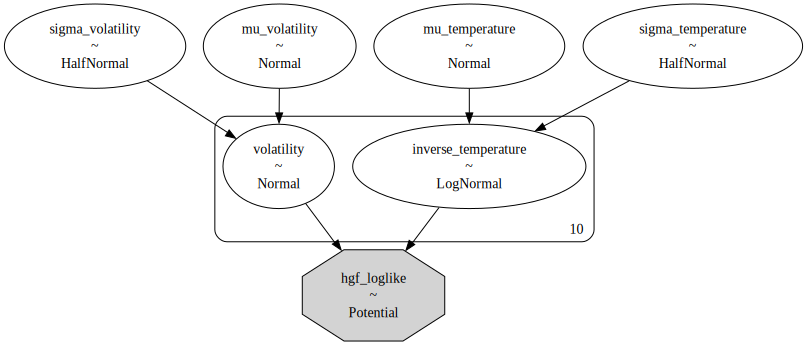

In [14]:
pm.model_to_graphviz(two_levels_binary_hgf)

## Sampling

In [15]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_volatility, sigma_volatility, volatility, mu_temperature, sigma_temperature, inverse_temperature]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Visualization of the posterior distributions

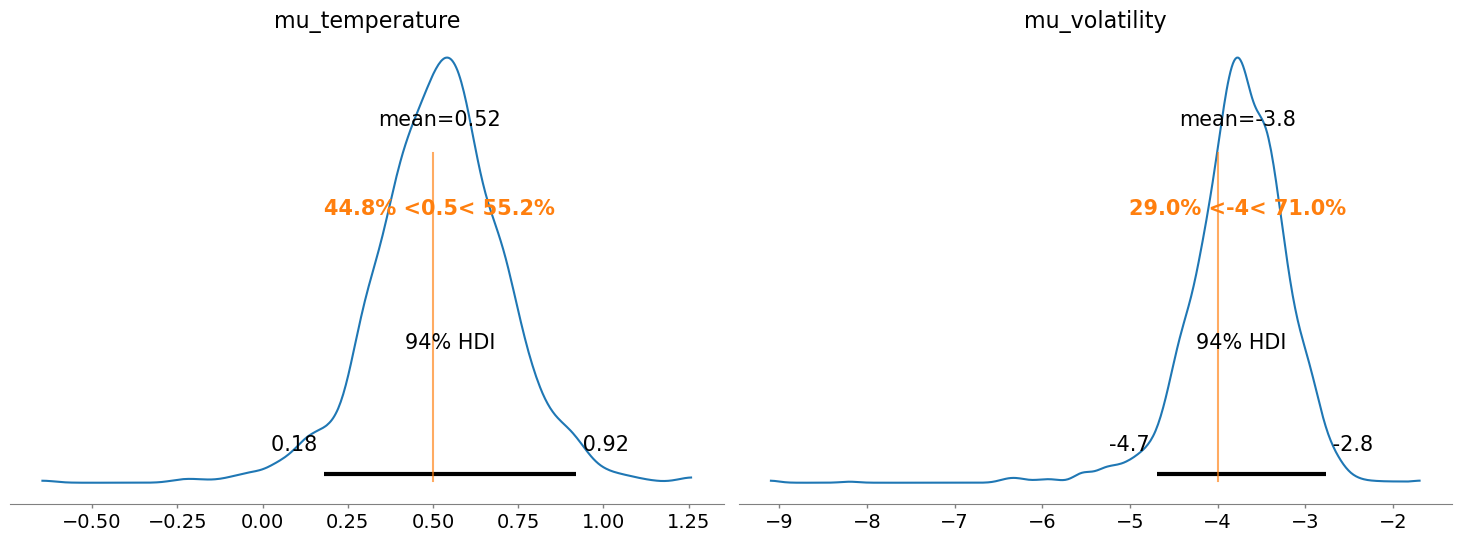

In [16]:
az.plot_posterior(two_level_hgf_idata, var_names=["mu_temperature", "mu_volatility"], ref_val=[.5, -4.0])
plt.tight_layout()

# System configuration

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Mar 15 2024

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.15
jax   : 0.4.19
jaxlib: 0.4.19

matplotlib: 3.7.1
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
pytensor  : 2.18.6
pymc      : 5.10.3
jax       : 0.4.19
numpy     : 1.22.0
arviz     : 0.16.1

Watermark: 2.4.3

